# Natural Policy Gradient with Function approximation

In [1]:
!pip install pymdptoolbox

In [1]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers  #to solve linear and quadratic optimization problems
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

In [3]:
class HiddenPrints:       #To suppress print statements during execution of library function
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards = np.random.rand(self.num_action,self.num_state,self.num_state)

## Utility Functions

In [5]:
def softmax(env,theta,phi):
    pi = np.zeros((env.num_state,env.num_action),dtype=float)
    for s in env.states:
        for a in env.actions:
            pi[s][a]=np.exp(np.dot(np.array(phi[s][a]),theta))
        pi[s]=pi[s]/np.sum(pi[s])
    return np.array(pi)

def P_matrix(env,pi):
    # Compute Transition probabilities P(s,s') using P(s'| s,a ) and pi( a|s ) : Matrix of size |s| x |s|
    P=np.empty((env.num_state,env.num_state),dtype=float)
    P=np.multiply(np.reshape(pi[:,0],(-1,1)),env.transitions[0][:][:])
    for a in range(1,env.num_action):
        P=P+np.multiply(np.reshape(pi[:,a],(-1,1)),env.transitions[a][:][:])
    return P
#Compute discounted state probability distribution      
def d_pi_s(env,P,gamma,s):
    e_s=np.zeros((env.num_state,1))
    e_s[s]=1
    i= np.identity(env.num_state)- gamma*(P)
    d= (1-gamma) * np.dot(np.linalg.inv(i),e_s)
    return d



## Policy Iteration 

In [10]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

## Evaluate Q values under policy pi

In [11]:
def evaluate_q(env, pi, gamma, V):
    Q = np.zeros((env.num_state,env.num_action))
    for s in env.states:
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            Q[s][a] = np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    return Q

## NPG with Function Approximation

### Compute 
#### $\widetilde{\phi}$<sub>s,a</sub>   :  $\phi$<sub>s,a</sub>       - (E<sub>a~$\pi$[.|s]</sub> $\phi\$<sub>s,a'</sub>)

In [12]:
def phi_tilde(env,pi,phi,s):
    phi_s=np.zeros(d)  #np.zeros replacee
    for a in env.actions:
        phi_s = phi_s+phi[s][a]*pi[s][a]
    #print(phi_s)
    return phi_s
           

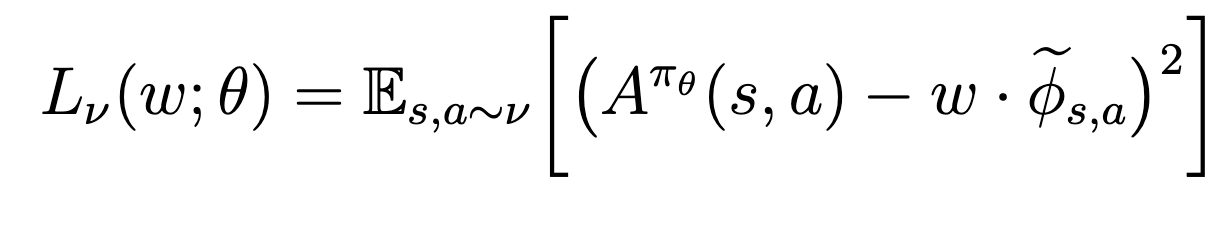
## Compute: 'w' = argmin <sub>$\omega$</sub> L<sub>$\nu$</sub>(w; $\theta$)


In [13]:
def argmin_wt(Q,p,d):
    Q = 2*matrix(Q)
    p = matrix(p)
    with HiddenPrints():
        sol=solvers.qp(Q,p)
    wt= np.array(sol['x'])
    return wt


## Natural Policy gradient with function approximation

In [2]:
def npg_funapprox(env,gamma,phi,EPS,rho,step_size,iterations,d,V_rho_optimal):
    theta = np.zeros((d,1))
    min_t = V_rho_optimal
    min_list=list()
    
    for i in range(0,iterations):
        pi = softmax(env,theta,phi)
        P = P_matrix(env,pi)
        V = evaluate_policy(env, pi, gamma, EPS)
        Q_pi = evaluate_q(env, pi, gamma, V)
        A = Q_pi-V
        Q = np.zeros((d,d))
        p = np.zeros(d)
        d_rho = np.zeros((env.num_state,1))
        for s in env.states:
            d_s = d_pi_s(env,P,gamma,s)
            d_rho = d_rho+ rho[s]*d_s
        for s in env.states:
            phi_tilde_s = phi_tilde(env,pi,phi,s)  #compute phi_tilde
            for a in env.actions:
                phi_t = (phi[s][a]-phi_tilde_s)
                phi_t = np.reshape(phi_t,(1,d))
                phi_t_t = np.reshape(phi_t,(d,1))
                Q = Q+ (d_rho[s]*pi[s][a]*np.dot(phi_t_t,phi_t))
                phi_t = (phi[s][a]-phi_tilde_s)
                p = p+ (-2*A[s][a]*d_rho[s][0]*pi[s][a]*phi_t)
        wt = argmin_wt(Q,p,d)          #compute w
        theta = theta + step_size*wt  #theta update
        V=evaluate_policy(env, pi, gamma, EPS) 
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)

    return theta,min_list   

## Example

In [15]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=10
a=2
d=10
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R

   
    

In [16]:
gamma = 0.9       #Discount rate
EPS = 0.0001    #A small positive number
rho= np.ones(env.num_state)/env.num_state
learning_rate=(1-gamma)**3/((2*gamma)*env.num_action)

start_time = time.time()
V_optimal_policy,pi_optimal_policy=policy_iteration(env, gamma, EPS)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.07364869117736816 seconds ---


In [17]:
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

In [18]:
np.random.seed(0)
phi = np.random.rand(env.num_state,env.num_action,d) #d=2

In [19]:
step_size = 0.5
iterations= 150
theta,min_list = npg_funapprox(env,gamma,phi,EPS,rho,step_size,iterations,d,V_rho_optimal)

In [20]:
pi_funapprox=softmax(env,theta,phi)
V_optimal_policy-evaluate_policy(env, pi_funapprox, gamma, EPS)

array([[0.00297301],
       [0.0025022 ],
       [0.00228452],
       [0.0066227 ],
       [0.00339759],
       [0.00414493],
       [0.00245409],
       [0.00255167],
       [0.00299955],
       [0.00317284]])

In [21]:
def plot_log(min_list,iterations):
    
    x=np.log(np.array(range(0,iterations)))
    y=np.log(np.array(min_list)[:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(min(V_opt-V(t)))', fontsize=12)
    plt.plot(x,y,color='blue', label='NPG Softmax with function Approximation') 
    #plt.title(title,fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

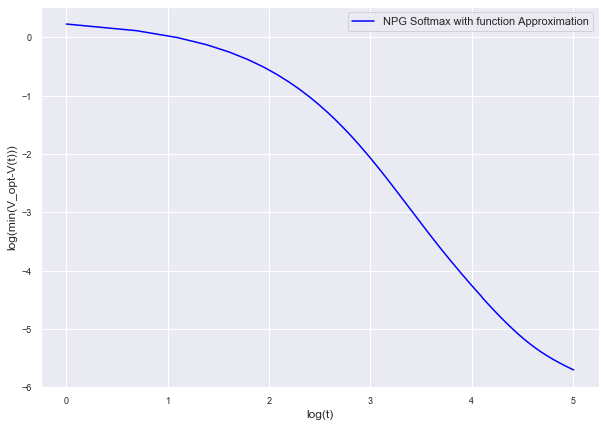

In [23]:
plot_log(min_list,iterations)